## Building a GPT

Companion notebook to the [Zero To Hero](https://karpathy.ai/zero-to-hero.html) video on GPT.

In [1]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
! wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-02-16 08:02:49--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 0.0.0.0
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|0.0.0.0|:443... failed: Connection refused.


In [2]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [3]:
# let's look at the first 1000 characters
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [4]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [5]:
# create a mapping from characters to integers
# 创建了一个名为stoi（"string to integer"的缩写）的字典。它使用了字典推导式，这是创建字典的一种简洁方式。
# enumerate(chars)函数，它接收一个可迭代对象（在这个例子中是chars），并返回一个产生形如(index, element)的元组的迭代器。换句话说，它将可迭代对象的每个元素与其对应的索引配对。
# for i,ch in enumerate(chars)部分的代码是一个for循环，它遍历这些(index, element)元组。i是索引，ch是来自chars可迭代对象的元素
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [6]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [7]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [8]:
block_size = 8
train_data[:block_size+1]

# :操作符用于指示切片或值范围。在这种情况下，train_data[:block_size+1]将返回一个新列表，该列表包含从train_data的开始到索引block_size（包含）的元素。
# Python使用基于零的索引，所以第一个元素在索引0处。因此，如果block_size是5，那么这段代码将返回train_data的前6个元素（索引0到5）。
# 需要注意的是，切片中的结束索引是独占的，这意味着它不包括该索引处的元素。然而，在这种情况下，我们对block_size加了1，所以索引block_size处的元素包含在切片中。

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [9]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
print(x)
print(y)
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

tensor([18, 47, 56, 57, 58,  1, 15, 47])
tensor([47, 56, 57, 58,  1, 15, 47, 58])
when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


In [10]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    # 生成一个长度为batch_size的一维张量，张量中的每个元素都是一个随机整数，这个整数的范围是0到len(data) - block_size。这些随机整数将被用作从数据中提取序列的起始索引。
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

In [11]:
print(xb) # our input to the transformer
print(yb)

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])


In [12]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        # 嵌入表将每个词汇（token）映射到一个向量，向量的大小等于词汇表的大小。
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            # B代表批量大小（batch size），T代表时间步长（time steps），C代表类别数量（class number）。这里的C是词汇表的大小。
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            # PyTorch的F.cross_entropy函数期望的输入是这样的形状：logits应该是一个二维张量，其中每一行对应一个输入样本，每一列对应一个类别；targets应该是一个一维张量，其中每个元素对应一个输入样本的类别索引。
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    # generate方法是模型的生成函数。它接收当前的上下文idx和最大新生成token的数量max_new_tokens，并生成一个新的序列。这个方法首先获取模型的预测，然后只关注最后一个时间步的logits。
    # 然后，它应用softmax函数来获取概率分布，从这个分布中采样下一个token的索引，然后将这个索引添加到当前的序列中。这个过程重复max_new_tokens次。
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            # F.softmax(logits, dim=-1)的作用是对logits的每一行（也就是每个样本的所有类别的输出）进行softmax操作。
            # softmax操作会将每个元素的值转换为0到1之间的值，并且所有元素的值的和为1。这样，每一行的值就可以被解释为一个概率分布，表示模型预测每个类别的概率。
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            # torch.cat函数来将idx和idx_next两个张量在第二个维度（dim=1）上进行拼接。
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

# 生成一个新的序列，将这个序列解码为文本，然后打印出这个文本。
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)

SKIcLT;AcELMoTbvZv C?nq-QE33:CJqkOKH-q;:la!oiywkHjgChzbQ?u!3bLIgwevmyFJGUGp
wnYWmnxKWWev-tDqXErVKLgJ


In [15]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [16]:
batch_size = 32
for steps in range(100): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())


4.531792163848877


In [17]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


oiWIgkOIVFTBcJrb$T;AcqKlVpJZR
RmntLvNAm:VHOdPyuFIGjsuJJv'VTbpQA'OEHA:CYSqo$-Ila;T;ABDC-zoiyxc;bO&X'FqVxBYW
rXlcnL,iKD3fRb$GRj;CKHAINSgfMOsIG3S&alyln;ERjmylkteErSPTH;I&CJTASLT'gdco..JGixYGSP P?:CXSjRc,SPlvCnpBMlv.iv-urbWy;RcfRm vU?Bq-bZF
pSnPl,ehiPhSA-cGNSP!z,OmEbfFA-gFOy:..dbfIotNmnErJpLfyFhi-iOl!IUCjRroxJBSGGSPZK;
p.ltFoiUCJkzPOLXXEca-jalyKl-UiPi-oX&zkzVjk!kD3TBTnUVcGjoggCjxElaye.JG-Ko-
SYguBigzPLLTRwNoa!PAfttS!PHQnC&XXcsullN:Cbf;aPytq--olgmQxfl, ajbtT!$
hORSxL3sByzPyNwNfpDEHFZ;itkyH?dagqHNYwd&


## The mathematical trick in self-attention

In [18]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
# torch.sum 计算张量a在第二个维度（dim=1）上的和。keepdim=True表示保持输出的维度
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [19]:
# consider the following toy example:

torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [20]:
# version 1: for loop and gather, use torch.mean
# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C))
# print(xbow)
for b in range(B):
    for t in range(T):
        # 使用切片操作x[b,:t+1]来获取x在第b个批次中前t+1个时间步的所有元素，得到一个形状为(t,C)的张量xprev。
        xprev = x[b,:t+1] # (t,C)
        # 使用torch.mean(xprev, 0)来计算xprev在第一个维度（dim=0）上的平均值。这个操作会返回一个形状为(C,)的张量，它的每个元素是xprev在对应列上的元素的平均值。
        xbow[b,t] = torch.mean(xprev, 0)
        
        print(b) if b==0 else None
        print(t) if b==0 else None
        print(xprev) if b==0 else None
        print(xbow[b,t]) if b==0 else None

0
0
tensor([[ 0.1808, -0.0700]])
tensor([ 0.1808, -0.0700])
0
1
tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152]])
tensor([-0.0894, -0.4926])
0
2
tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255]])
tensor([ 0.1490, -0.3199])
0
3
tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643]])
tensor([ 0.3504, -0.2238])
0
4
tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679]])
tensor([0.3525, 0.0545])
0
5
tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102]])
tensor([ 0.0688, -0.0396])
0
6
tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398]])
tensor([ 0.0927, -0.0

In [21]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
print(wei)
wei = wei / wei.sum(1, keepdim=True)
print("wei===")
print(wei)
print(x.shape)
print(wei.shape)
xbow2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)
print("x[2]")
print(x[2])
print("xbow2===")
print(xbow2[2])
torch.allclose(xbow, xbow2)

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])
wei===
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])
torch.Size([4, 8, 2])
torch.Size([8, 8])
x[2]
tensor([[-0.6631,

True

In [22]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
print("tril===")
print(tril)
wei = torch.zeros((T,T))
print("wei===")
print(wei)

# 将wei中对应tril == 0为True的元素替换为负无穷。也就是说，如果tril的某个元素等于0，那么wei的对应元素就会被替换为负无穷。
wei = wei.masked_fill(tril == 0, float('-inf'))
print("wei===")
print(wei)
wei = F.softmax(wei, dim=-1)
print("wei===")
print(wei)
xbow3 = wei @ x
print("result===")
print(x[0])
print(xbow3[0])
torch.allclose(xbow, xbow3)


tril===
tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])
wei===
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
wei===
tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf]

True

In [27]:
# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
# 定义了一个线性变换层，它接收一个形状为(N, C)的输入，返回一个形状为(N, head_size)的输出。这个线性变换层的权重矩阵的形状是(C, head_size)，它没有偏置向量（bias vector），因为bias=False。
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v
#out = wei @ x

print(k.shape)
print(q.shape)
print("========")
print(wei.shape)
print(v.shape)
print(out.shape)

torch.Size([4, 8, 16])
torch.Size([4, 8, 16])
torch.Size([4, 8, 8])
torch.Size([4, 8, 16])
torch.Size([4, 8, 16])


In [26]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

In [30]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

In [31]:
k.var()

tensor(1.0966)

In [32]:
q.var()

tensor(0.9416)

In [33]:
wei.var()

tensor(1.0065)

In [34]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [35]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1) # gets too peaky, converges to one-hot

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

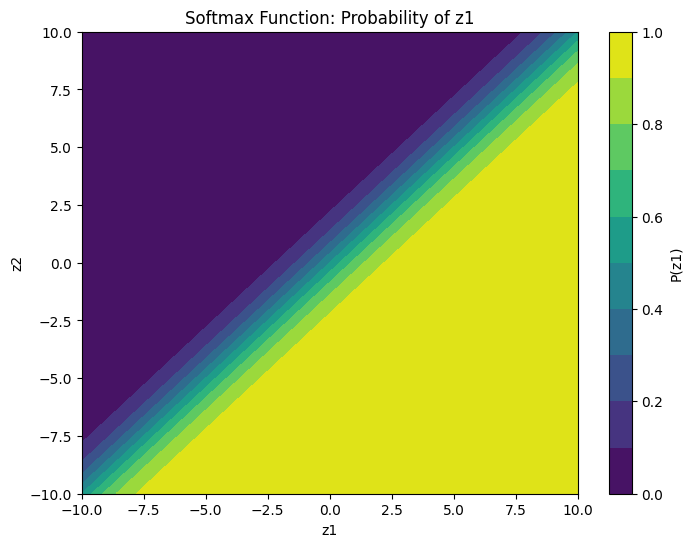

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# 定义 Softmax 函数
def softmax(z):
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z)

# 创建一个二维网格，用于绘制图像
z1 = np.linspace(-10, 10, 100)
z2 = np.linspace(-10, 10, 100)
Z1, Z2 = np.meshgrid(z1, z2)
Z = np.array([softmax([z1, z2]) for z1, z2 in zip(np.ravel(Z1), np.ravel(Z2))])

# 提取 Softmax 输出的第一个元素，即概率 P(z1)
P_z1 = Z[:, 0].reshape(Z1.shape)

# 绘制图像
plt.figure(figsize=(8, 6))
contour = plt.contourf(Z1, Z2, P_z1, cmap='viridis', levels=np.linspace(0, 1, 11))
plt.colorbar(contour, label='P(z1)')
plt.xlabel('z1')
plt.ylabel('z2')
plt.title('Softmax Function: Probability of z1')
plt.show()


In [40]:
class LayerNorm1d: # (used to be BatchNorm1d)

# dim是输入的特征维度，eps是一个很小的数，用于防止除以0，momentum是用于计算移动平均的动量，但在这个类中并没有使用。
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out
  # 计算了输入x在第二个维度（dim=1）上的均值和方差，然后用x减去均值，再除以标准差，得到了归一化后的xhat。最后，我们用gamma乘以xhat，再加上beta，得到了输出。

  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [41]:
x[:,0].mean(), x[:,0].std() # mean,std of one feature across all batch inputs

(tensor(0.1469), tensor(0.8803))

In [42]:
x[0,:].mean(), x[0,:].std() # mean,std of a single input from the batch, of its features

(tensor(-3.5763e-09), tensor(1.0000))

In [ ]:
# French to English translation example:

# <--------- ENCODE ------------------><--------------- DECODE ----------------->
# les réseaux de neurones sont géniaux! <START> neural networks are awesome!<END>



### Full finished code, for reference

You may want to refer directly to the git repo instead though.

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# 超参数设置
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# 1. 数据处理
# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# 2. 数据集划分
# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# 3. 数据分批
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# 4. 模型评估
# 评估模型在训练集和验证集上的平均损失。这个函数的实现非常简单：它首先将模型设置为评估模式，然后对每个数据集进行eval_iters次迭代。
# 在每次迭代中，它获取一个小批量数据，然后计算模型的输出和损失。最后，它返回每个数据集的平均损失。
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# 5. 模型head定义
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        # 创建一个下三角矩阵，并将其注册为模型的一个缓冲区。
        # 这个下三角矩阵将被用作self-attention的权重矩阵，它将确保模型只能在当前时间步之前的时间步上进行自注意力操作。
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

# 6. 模型MultiHeadAttention定义
# 实现多头自注意力机制。在这个机制中，我们并行地进行多次自注意力计算，然后将结果拼接起来，通过一个线性层和一个dropout层进行处理，得到最终的输出。
# 这种方法可以让模型在不同的表示子空间中学习输入的不同特征。
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    # __init__方法是类的构造函数，它接收两个参数：num_heads和head_size。num_heads是注意力头的数量，head_size是每个注意力头的大小。
    # 创建了一个nn.ModuleList，它包含了num_heads个Head对象。我们还定义了一个线性层self.proj和一个dropout层self.dropout。
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    # forward方法定义了前向传播的计算过程。首先，我们对每个注意力头h进行计算，然后将结果在最后一个维度上拼接起来，得到out。
    # 然后，我们将out输入到线性层和dropout层，得到最终的输出。
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

# 7. 模型FeedFoward定义
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    # 在__init__方法中，我们首先调用了父类的构造函数，然后定义了一个神经网络self.net。这个神经网络是一个nn.Sequential对象，
    # 它包含了两个线性层和一个ReLU激活函数，以及一个dropout层。
    # 第一个线性层将输入的维度扩大到4 * n_embd，然后通过ReLU激活函数进行非线性变换，然后第二个线性层将维度缩小回n_embd，最后通过dropout层进行正则化。
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

# 8. 模型Block定义，layerNorm, multiheadattention, layerNorm, feedforward
# Block类的作用是实现一个Transformer模型中的一个块。这个块包含了一个多头自注意力模块和一个前馈神经网络模块，以及两个层归一化操作。
# 这种结构可以让模型在处理序列数据时，能够同时考虑到每个位置的信息和全局的信息。
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    # forward方法定义了前向传播的计算过程。首先，我们将输入x进行层归一化，然后输入到自注意力模块中，得到的输出与原始的x相加，得到新的x。
    # 然后，我们将新的x进行层归一化，然后输入到前馈神经网络中，得到的输出与原始的x相加，得到最终的输出。
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# 9. 模型BigramLanguageModel定义
# super simple bigram model，训练一个二元语言模型，并生成新的文本。
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    # forward方法定义了前向传播的计算过程。首先，我们从词嵌入表和位置嵌入表中获取嵌入，然后将它们相加得到x。
    # 然后，我们将x输入到self.blocks中，然后进行层归一化，然后输入到self.lm_head中，得到logits。如果提供了目标，我们会计算交叉熵损失。
    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    # 将当前的索引裁剪到最后的block_size个令牌，然后获取预测的logits，然后只关注最后一个时间步，然后应用softmax得到概率，然后从分布中采样，然后将采样的索引添加到运行的序列中。
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


# 10. 模型实例化
model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
# 将其移动到设备device上。然后，我们打印出模型中的参数数量。
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # 从训练集中采样一个批次的数据xb和yb，然后将它们输入到模型中，得到logits和loss。然后，我们将优化器的梯度清零，然后计算损失的反向传播，然后更新优化器的参数。
    # 采样一个批次的数据，计算损失，清零梯度，计算反向传播，然后更新参数。这是训练神经网络模型的基本步骤。
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    # 清零优化器的梯度。这是因为PyTorch的优化器在每次更新参数时都会累积梯度，所以在每次更新参数之前，我们需要清零梯度。
    optimizer.zero_grad(set_to_none=True)
    # 计算损失的反向传播。这会计算出每个参数的梯度。
    loss.backward()
    # 更新优化器的参数。这会根据每个参数的梯度和学习率来更新参数的值。
    optimizer.step()

# generate from the model
# 用模型来生成新的文本，首先创建一个全零的上下文context，然后将其输入到模型的generate方法中，得到生成的文本，然后将其解码并打印出来。
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


0.209729 M parameters
step 0: train loss 4.4116, val loss 4.4022
step 100: train loss 2.6568, val loss 2.6670
step 200: train loss 2.5091, val loss 2.5059
step 300: train loss 2.4196, val loss 2.4336
step 400: train loss 2.3498, val loss 2.3560
step 500: train loss 2.2964, val loss 2.3130
step 600: train loss 2.2406, val loss 2.2497
step 700: train loss 2.2052, val loss 2.2185
step 800: train loss 2.1633, val loss 2.1861
step 900: train loss 2.1246, val loss 2.1511
step 1000: train loss 2.1036, val loss 2.1309
step 1100: train loss 2.0709, val loss 2.1196
step 1200: train loss 2.0381, val loss 2.0794
step 1300: train loss 2.0243, val loss 2.0633
step 1400: train loss 1.9929, val loss 2.0362
step 1500: train loss 1.9711, val loss 2.0313
step 1600: train loss 1.9633, val loss 2.0484
step 1700: train loss 1.9410, val loss 2.0126
step 1800: train loss 1.9111, val loss 1.9973
step 1900: train loss 1.9103, val loss 1.9877
step 2000: train loss 1.8853, val loss 1.9945
step 2100: train loss 1.